In [ ]:
!pip install numpy scipy pywavelets opencv-python matplotlib

In [ ]:
import numpy as np
import scipy.io
import pywt
import os
import cv2
import matplotlib.pyplot as plt


In [25]:
# .mat file summary
# Ensure the .mat file exists in the current directory
file_name = 'forces_xyz_raw.mat'
# Print the current working directory
print(os.getcwd())

if not os.path.exists(file_name):
    print(f"Error: '{file_name}' not found in the current directory!")
    exit()


# Load the MATLAB file
data = scipy.io.loadmat('forces_xyz_raw.mat')

def summarize_mat(data):
    # Get the top-level variables
    print("Top-level variables in the .mat file:")
    for key, value in data.items():
        # Avoid the meta info introduced by scipy
        if not key.startswith("__"):
            print(f"\nVariable: {key}")
            print(f"Type: {type(value)}")

            # If it's an ndarray (which includes MATLAB matrices, arrays, and cell arrays)
            if isinstance(value, np.ndarray):
                print(f"Shape: {value.shape}")

                # For cell arrays (dtype=object in the case of scipy's loading of .mat files)
                if value.dtype == 'O':
                    # Let's peek into the first few cells to understand their content
                    cell_summary = set()
                    for i in range(min(5, value.size)):  # up to 5 cells
                        cell_data = value.flat[i]
                        cell_summary.add(f"Type: {type(cell_data)}, Shape: {cell_data.shape if isinstance(cell_data, np.ndarray) else 'N/A'}")

                    print("Sample cells content:")
                    for s in cell_summary:
                        print(f"  - {s}")

                # For matrices/arrays, show a snippet
                else:
                    print(f"Sample Data: {value[:5]}")  # first 5 elements

            # Other types (not expected in standard .mat files, but just in case)
            else:
                print(value)

# Provide the summary
summarize_mat(data)

/content
Top-level variables in the .mat file:

Variable: baseDatastore
Type: <class 'numpy.ndarray'>
Shape: (512, 5)
Sample cells content:
  - Type: <class 'numpy.ndarray'>, Shape: (1,)
  - Type: <class 'scipy.io.matlab._mio5_params.MatlabOpaque'>, Shape: (1,)
  - Type: <class 'numpy.ndarray'>, Shape: (3, 97719)
  - Type: <class 'numpy.ndarray'>, Shape: (1, 1)


<ipython-input-24-16edb4c2e87b>:11: RuntimeWarning: divide by zero encountered in log10
  scalogram_dB = 10 * np.log10(np.abs(coefficients)**2)


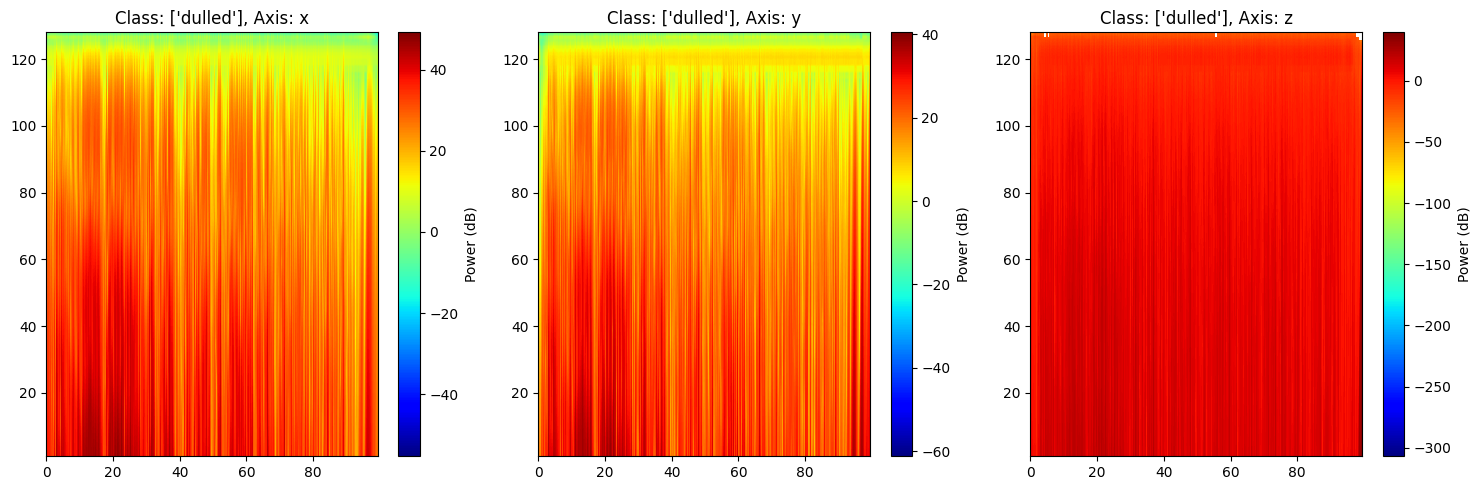

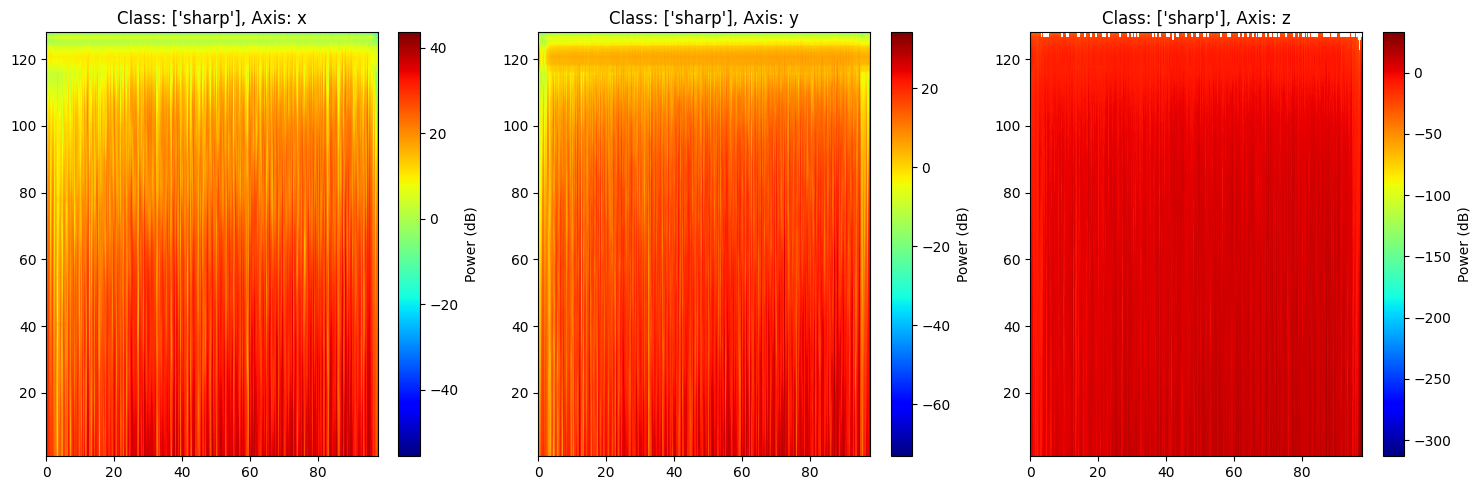

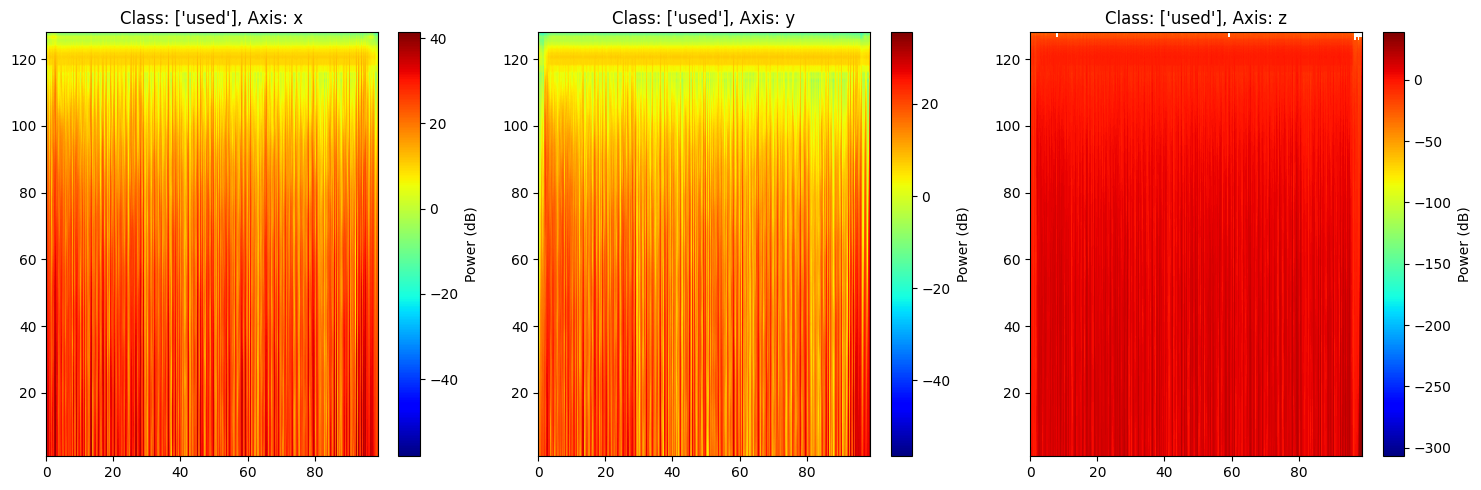

In [24]:
# Sample visualisation
#  Load the MATLAB file
data = scipy.io.loadmat('forces_xyz_raw.mat')
baseDatastore = data['baseDatastore']

# Extract the unique classes
classes = np.unique([item[1][0] for item in baseDatastore])

# Visualization function
def visualize_scalogram(force_signal):
    coefficients, frequencies = pywt.cwt(force_signal, scales=np.arange(1,128), wavelet='cmor', sampling_period=1/1000.0)
    scalogram_dB = 10 * np.log10(np.abs(coefficients)**2)
    plt.imshow(scalogram_dB, aspect='auto', cmap='jet', extent=[0, len(force_signal)/1000.0, 1, 128])

# For each class, visualize a sample scalogram for x, y, and z forces
for cls in classes:
    samples = [instance for instance in baseDatastore if instance[1][0] == cls]
    sample = samples[0]  # take the first sample for visualization
    forces = sample[3]

    plt.figure(figsize=(15, 5))

    for idx, axis in enumerate(['x', 'y', 'z']):
        plt.subplot(1, 3, idx+1)
        visualize_scalogram(forces[idx, :])
        plt.title(f'Class: {cls}, Axis: {axis}')
        plt.colorbar(label='Power (dB)')

    plt.tight_layout()
    plt.show()

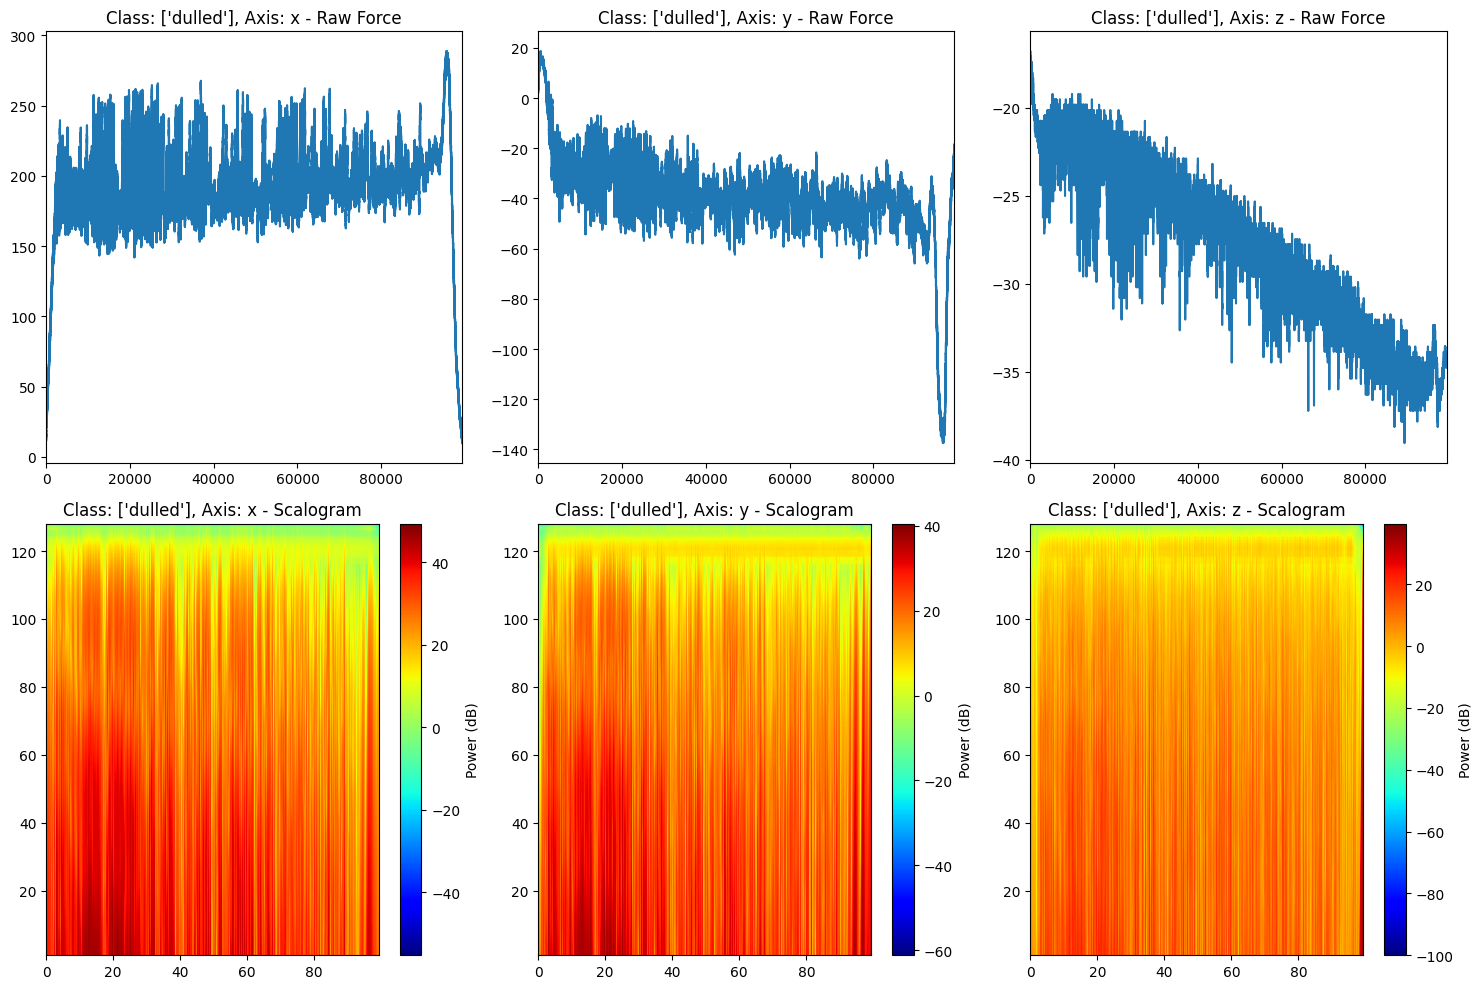

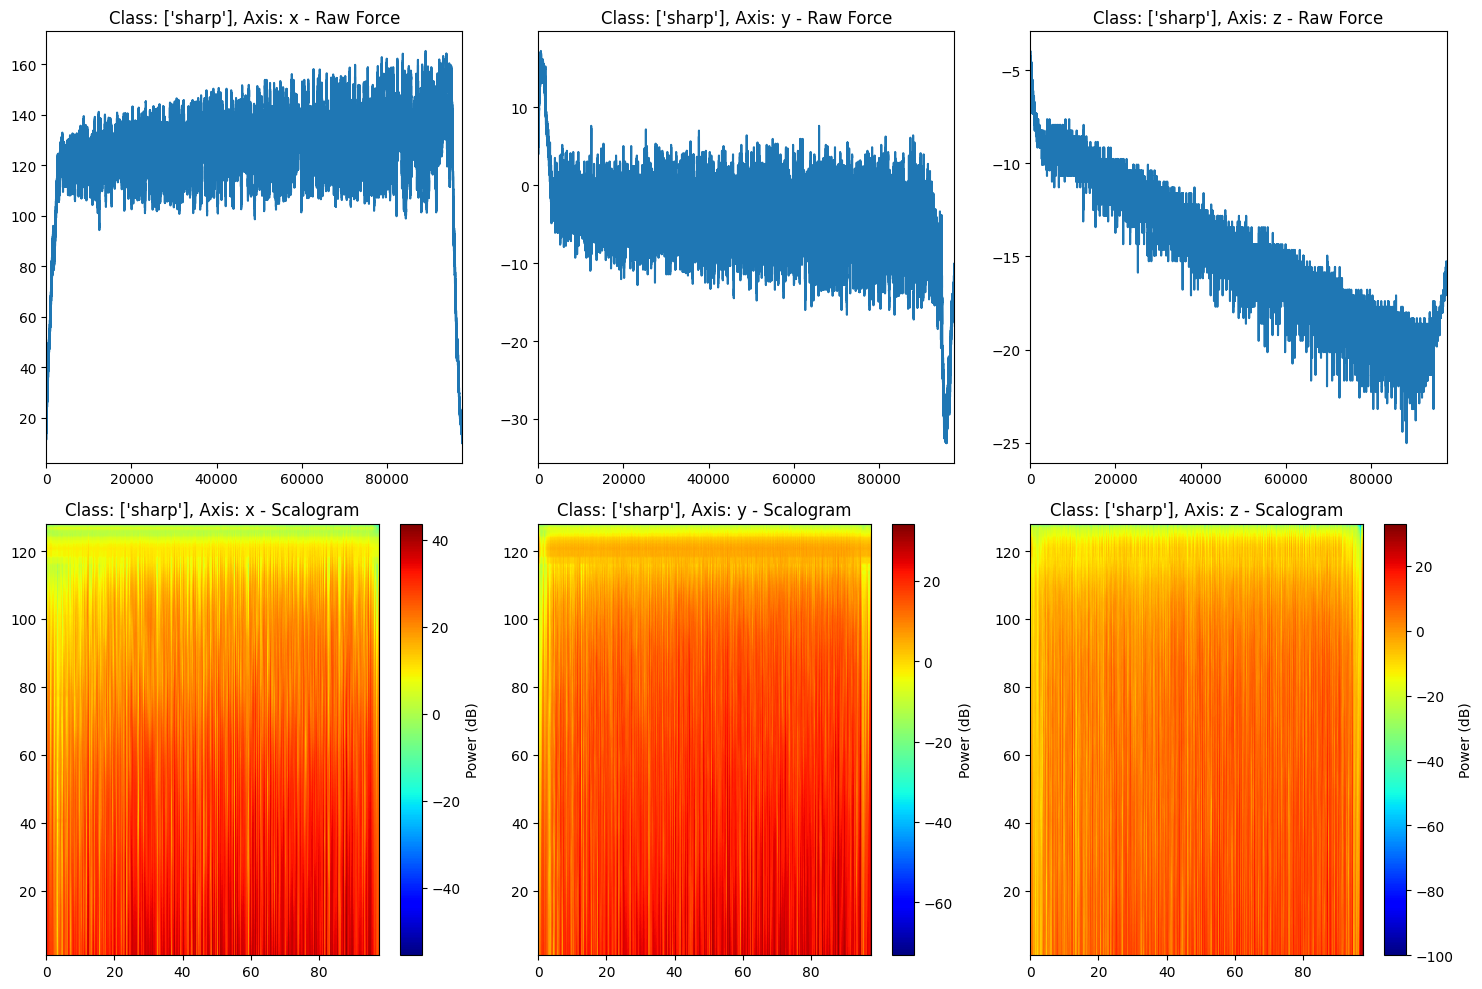

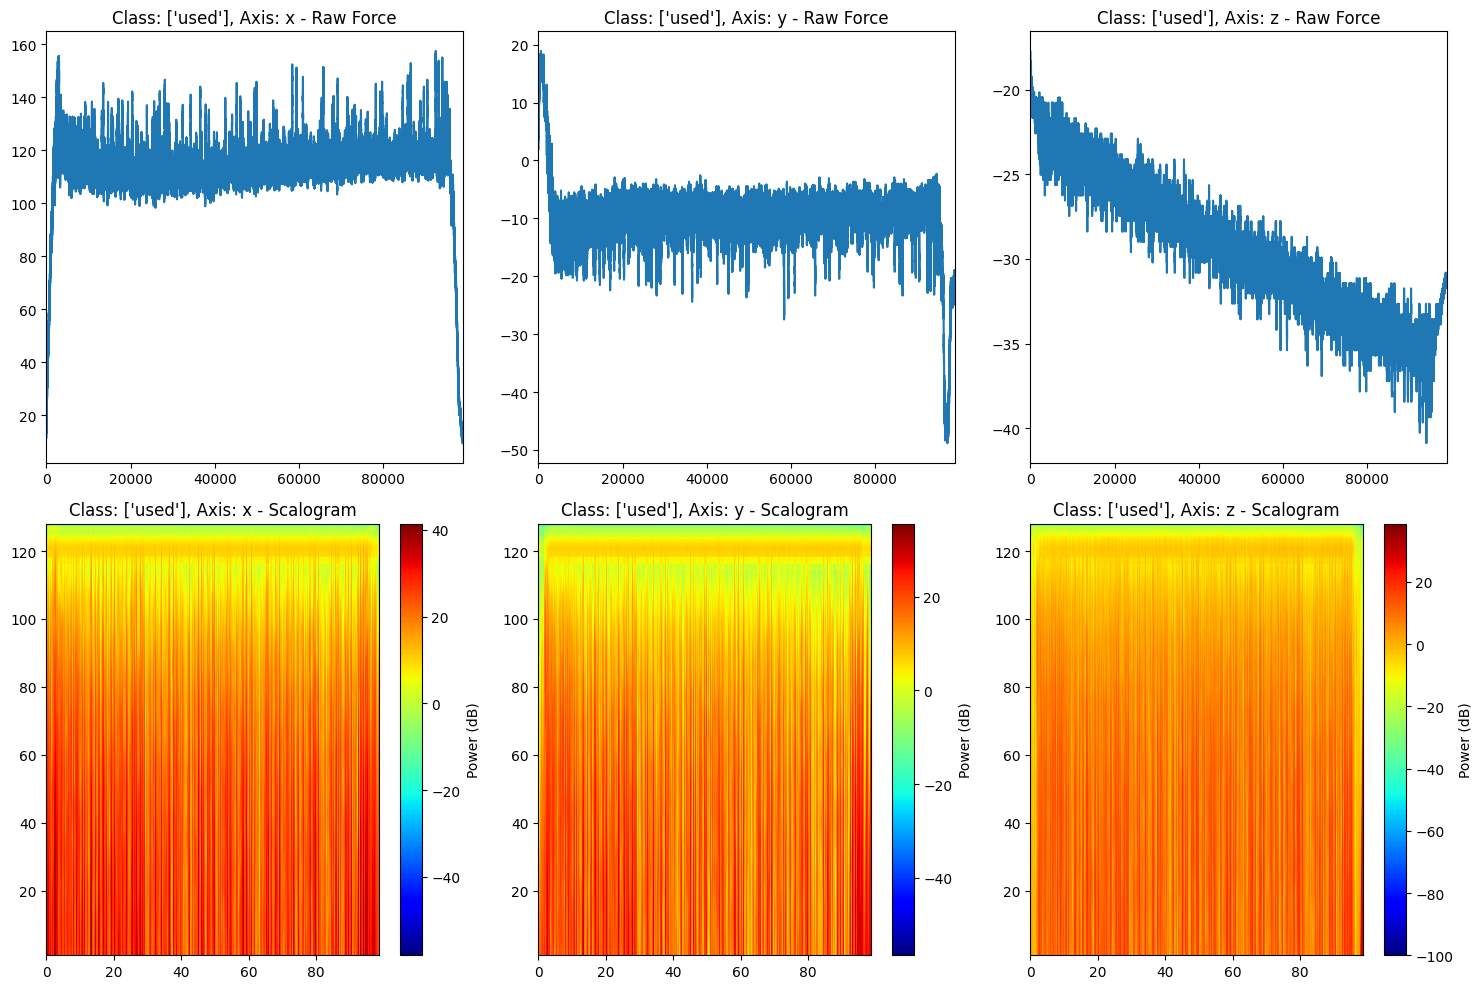

In [29]:
# 1. Load the MATLAB file
data = scipy.io.loadmat('forces_xyz_raw.mat')
baseDatastore = data['baseDatastore']

# Extract the unique classes
classes = np.unique([item[1][0] for item in baseDatastore])

def visualize_scalogram(force_signal, ax):
    coefficients, frequencies = pywt.cwt(force_signal, scales=np.arange(1,128), wavelet='cmor', sampling_period=1/1000.0)
    scalogram_dB = 10 * np.log10(np.abs(coefficients)**2 + 1e-10)  # added a small value to avoid log(0)

    # Storing the returned object of imshow in im variable
    im = ax.imshow(scalogram_dB, aspect='auto', cmap='jet', extent=[0, len(force_signal)/1000.0, 1, 128])

    # Only add colorbar if there's content in the scalogram
    if not np.all(scalogram_dB == 0):
        plt.colorbar(im, label='Power (dB)', ax=ax)




def visualize_raw_force(force_signal, ax):
    ax.plot(force_signal)
    ax.set_xlim([0, len(force_signal)])
    ax.set_title('Raw Force Signal')

# For each class, visualize a sample scalogram and raw force for x, y, and z forces
for cls in classes:
    samples = [instance for instance in baseDatastore if instance[1][0] == cls]
    sample = samples[0]  # take the first sample for visualization
    forces = sample[3]

    plt.figure(figsize=(15, 10))

    for idx, axis in enumerate(['x', 'y', 'z']):
        # Plot raw force amplitude
        ax1 = plt.subplot(2, 3, idx+1)
        visualize_raw_force(forces[idx, :], ax1)
        ax1.set_title(f'Class: {cls}, Axis: {axis} - Raw Force')

        # Plot scalogram
        ax2 = plt.subplot(2, 3, idx+4)
        visualize_scalogram(forces[idx, :], ax2)
        ax2.set_title(f'Class: {cls}, Axis: {axis} - Scalogram')

    plt.tight_layout()
    plt.show()

In [17]:
# Create scalograms
# Load the MATLAB file
data = scipy.io.loadmat('forces_xyz_raw.mat')
baseDatastore = data['baseDatastore']

# Create the main folder and subfolders if they don't exist
os.makedirs('spec', exist_ok=True)
os.makedirs(os.path.join('spec', 'x'), exist_ok=True)
os.makedirs(os.path.join('spec', 'y'), exist_ok=True)
os.makedirs(os.path.join('spec', 'z'), exist_ok=True)

# Process each force sequence in baseDatastore
for instance in baseDatastore:
    # Extract data
    name = instance[0][0].replace('.jpg', '.png')
    forces = instance[3]

    for idx, axis in enumerate(['x', 'y', 'z']):
        force_signal = forces[idx, :]

        # 2. & 3. Create scalogram
        coefficients, frequencies = pywt.cwt(force_signal, scales=np.arange(1,128), wavelet='cmor', sampling_period=1/1000.0)
        scalogram_dB = 10 * np.log10(np.abs(coefficients)**2)

        # Save scalogram to the appropriate folder
        plt.imshow(scalogram_dB, aspect='auto', cmap='jet', extent=[0, len(force_signal)/1000.0, 1, 128])
        plt.axis('off')
        plt.savefig(os.path.join('spec', axis, name), bbox_inches='tight', pad_inches=0)
        plt.clf()

print("Scalograms saved successfully.")


/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
<ipython-input-17-7b801eb3bf32>:29: RuntimeWarning: divide by zero encountered in log10
  scalogram_dB = 10 * np.log10(np.abs(coefficients)**2)


Scalograms saved successfully.


<Figure size 640x480 with 0 Axes>

In [ ]:
# Downloading scalograms
from google.colab import files
# Compress the 'spec' folder into a zip file
!zip -r spec.zip spec

# Download the zip file
files.download('spec.zip')